# 05. Exploring the impact of cyclones on vegetation: fractional cover

This notebook creates returns Fractional Cover (FC) imagery for the scene directly before and directly after a tropical cyclone. 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx The difference of NDVI before and after the tropical cylone is then visualised. Finally, the notebook is used to import cyclone windfield data and examine the relationship between wind speed and NDVI change.

Cells titled "user requirement" indicate where users are required to edit code, the remaining code should be run normally. 

Code written in Janurary 2018 by Erin Telfer with support from Claire Krause. The notebook was completed as a graduate program project at Geoscience Australia. If you have comment or if you find an error, please contact erin.telfer@ga.gov.au. Alternatively, please contact Claire.Krause@ga.gov.au.

In [1]:
#Import libraries 

%pylab notebook

import pandas as pd
import xarray as xr
from datetime import date, timedelta
import gdal
from gdal import *

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.masking import make_mask


from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display
import ipywidgets as widgets
import rasterio
import seaborn as sns
sns.set(color_codes=True)

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specify directory locations

In [2]:
###User input: enter the directory location of input data. Ensure "/" are used, not "\"
input_folder = '/g/data/w85/ext547/input_data/'

###User input: enter the directory location of output data. Please enter again if the same as input_folder. Ensure "/" are used, not "\"
output_folder = '/g/data/w85/ext547/cyclone_repo/output_data/'

# User requirement: specifiy location of interest and details about cyclone

In [3]:
###User input: enter area of interest

lat_min = -20.267 #down
lat_max = -20.216 #up
lon_min = 148.534 #left
lon_max = 148.592 #right

#High Mt QLD
# lat_min = -20.375 #down
# lat_max = -20.340 #up
# lon_min = 148.757 #left
# lon_max = 148.806 #right

# lat_min = -20.385 #down
# lat_max = -20.326 #up
# lon_min = 148.916 #left
# lon_max = 148.984 #right

##User input: enter the name of vegetation of interest, e.g. "forest" or "banana crop"
vegetation_type = 'forest'

##User input: enter the name of the area/region/place/location of interest, e.g. "Hamilton Island"
location_name = 'Mt Dryander QLD'

###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input: enter the name of cyclone
cyclone_name =  'Debbie'

###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.80 

# Datacube query is completed

In [4]:
#Temporal range, wavelengths/band and sensors of interest are defined

#temporal range is defined
start_of_epoch = '2000-01-01'
end_of_epoch =  '2017-12-31'

#Landsat sensors of interest are defined
sensors = ['ls8',
     'ls7',
     'ls5'] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2017-12-31'), 'x': (148.534, 148.592), 'y': (-20.216, -20.267), 'crs': 'EPSG:4326'}


In [5]:
#Reformat variables

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime
location_name=location_name.replace(" ","_") #replace spaces with underscore

# Data is extracted from Open Datacube

The extracted data is first filtered using the criteria in "mask_components". 
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded.
Additionally, any pixel that is located within the ocean/sea will be converted to "nan" values with the 'land_sea' command.

In [6]:
# #Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

basic_pq_mask = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea': 'land'}

In [13]:
sensor_clean = {}
for sensor in sensors: 
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'fc')
    print('loading {}'.format(product_name))
    
        # load FC and PQ
    fc = dc.load(product=sensor + '_fc_albers', group_by='solar_day', **query)
    pq = dc.load(product=sensor + '_pq_albers', group_by='solar_day', **query, fuse_func=ga_pq_fuser)
        
    crs = fc.crs
    crswkt = fc.crs.wkt
    affine = fc.affine
        
    # find common observations
    time = (fc.time - pq.time).time  # works!
    fc = fc.sel(time=time)
    pq = pq.sel(time=time)
    
    # mask
    basic_mask = make_mask(pq, **basic_pq_mask).pixelquality
    fc = fc.where(basic_mask)
    
    cloud_free = make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud').pixelquality
    
    mostly_cloud_free = cloud_free.mean(dim=('x', 'y')) >= cloud_free_threshold
    # should cloud_free be replaced with cloud_free.where(basic_mask)?
    
    # only those observations that were mostly cloud free
    result = fc.where(mostly_cloud_free).dropna(dim='time', how='all')
    
    result.attrs['crs'] = crs
    result.attrs['affine'] = affine
    
    result.coords['product'] = ('time', numpy.repeat(sensor, result.time.size))
    sensor_clean[sensor] = result

print ('complete')


loading ls8_fc_albers
loading ls7_fc_albers
loading ls5_fc_albers
complete


In [8]:
# sensor_clean = {}
# for sensor in sensors: 
#     dataset = []
#     product_name = '{}_{}_albers'.format(sensor, 'fc')
#     print('loading {}'.format(product_name))
    
#         # load FC and PQ
#     fc = dc.load(product=sensor + '_fc_albers', group_by='solar_day', **query)
#     pq = dc.load(product=sensor + '_pq_albers', group_by='solar_day', **query, fuse_func=ga_pq_fuser)
    
#     # find common observations
#     time = (fc.time - pq.time).time  # works!
#     fc = fc.sel(time=time)
#     pq = pq.sel(time=time)
    
#     # mask
#     basic_mask = make_mask(pq, **basic_pq_mask).pixelquality
#     fc = fc.where(basic_mask)
    
#     cloud_free = make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud').pixelquality
    
#     mostly_cloud_free = cloud_free.mean(dim=('x', 'y')) >= cloud_free_threshold
#     # should cloud_free be replaced with cloud_free.where(basic_mask)?
    
#     # only those observations that were mostly cloud free
#     result = fc.where(mostly_cloud_free).dropna(dim='time', how='all')
#     result.coords['sensor'] = ('time', numpy.repeat(sensor, result.time.size))
#     print(result)
#     sensor_clean[sensor] = result.coords['sensor']
#     print (sensor_clean)

# print ('complete')

In [9]:
# #def load_fc(sensor,query,bands_of_interest):
# '''loads fractional cover data for a sensor, masks using pq, then filters out terrain -999s 
# function written 22-11-2017 based on dc v1.5.3 BexDunn''' 

# sensor_clean = {}
# for sensor in sensors: 
#     dataset = []
#     product_name = '{}_{}_albers'.format(sensor, 'fc')
#     print('loading {}'.format(product_name))
    
#     ds_fc = dc.load(product=product_name, group_by='solar_day', **query)
    
#     print (ds_fc.time)
#     #grab crs defs from loaded ds if ds exists
#     if ds_fc:
#         crs = ds_fc.crs
#         affine = ds_fc.affine
#         mask_product = '{}_{}_albers'.format(sensor, 'pq')
#         sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
#                             group_by='solar_day', **query)
#         print (sensor_pq.time)
        
#         if sensor_pq:
#             sensor_fc = ds_fc.sel(time = sensor_pq.time)
            
#             quality_mask = masking.make_mask(sensor_pq, **mask_components)
#             good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
#             sensor_nbar2 = sensor_fc.where(good_data)
            
#             cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
#                                    contiguous=True).pixelquality

#             mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
            
#             ds = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')

#             ds.attrs['affine'] = affine
#             print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            
#             ###CHECKME - fractional cover nodata values are -1
#             ds=ds.where(ds!=-1)
            
#             sensor_clean[sensor] = ds
            
            
            
#             print('loaded {}'.format(product_name))
#         else: 
#             print('did not mask {} with {}'.format(product_name,mask_product))
#     else:
#         print ('did not load {}'.format(product_name))    
# print ('complete')

In [10]:
# #def load_fc(sensor,query,bands_of_interest):
# '''loads fractional cover data for a sensor, masks using pq, then filters out terrain -999s 
# function written 22-11-2017 based on dc v1.5.3 BexDunn''' 

# sensor_clean = {}
# for sensor in sensors: 
#     ds = []
#     product_name = '{}_{}_albers'.format(sensor, 'fc')
#     print('loading {}'.format(product_name))
#     ds = dc.load(product=product_name, group_by='solar_day', **query)
    
#     #grab crs defs from loaded ds if ds exists
#     if ds:
#         crs = ds.crs
#         affine = ds.affine
#         mask_product = '{}_{}_albers'.format(sensor, 'pq')
#         sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
#                             group_by='solar_day', **query)
        
        
#         if sensor_pq:
#             cloud_free = masking.make_mask(sensor_pq,
#                                            cloud_acca='no_cloud',
#                                            cloud_shadow_acca = 'no_cloud_shadow',                           
#                                            cloud_shadow_fmask = 'no_cloud_shadow',
#                                            cloud_fmask='no_cloud',
#                                            blue_saturated = False,
#                                            green_saturated = False,
#                                            red_saturated = False,
#                                            nir_saturated = False,
#                                            swir1_saturated = False,
#                                            swir2_saturated = False,
#                                            contiguous=True,
#                                            land_sea= 'land').pixelquality

#             mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold

#             ds2 = ds.where(mostly_cloud_free).dropna(dim='time', how='all')
#             ds2.attrs['crs'] = crs
#             ds2.attrs['affine'] = affine
#             print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            
#             ###CHECKME - fractional cover nodata values are -1
#             ds2=ds2.where(ds!=-1)
#             sensor_clean[sensor] = ds2
                        
#             print('loaded {}'.format(product_name))
#         else: 
#             print('did not mask {} with {}'.format(product_name,mask_product))
#     else:
#         print ('did not load {}'.format(product_name))    
# print ('complete')

In [14]:
#Data from different sensors are joined together and sorted so that observations are sorted by time rather than sensor
fc_clean = xr.concat(sensor_clean.values(), 'time')
fc_clean = fc_clean.sortby('time')
fc_clean.attrs['crs'] = crs
fc_clean.attrs['affin|e'] = affine

In [15]:
#Check that the concatenation worked

fc_clean

<xarray.Dataset>
Dimensions:  (time: 183, x: 269, y: 257)
Coordinates:
  * y        (y) float64 -2.279e+06 -2.279e+06 -2.279e+06 -2.279e+06 ...
  * x        (x) float64 1.714e+06 1.714e+06 1.714e+06 1.714e+06 1.714e+06 ...
  * time     (time) datetime64[ns] 2000-06-30T23:56:29.500000 ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' ...
Data variables:
    BS       (time, y, x) float64 1.0 0.0 0.0 6.0 7.0 0.0 0.0 0.0 0.0 0.0 ...
    PV       (time, y, x) float64 90.0 75.0 79.0 83.0 87.0 98.0 77.0 84.0 ...
    NPV      (time, y, x) float64 7.0 24.0 20.0 10.0 4.0 0.0 23.0 16.0 2.0 ...
    UE       (time, y, x) float64 27.0 26.0 28.0 27.0 30.0 31.0 32.0 34.0 ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1713675.00|\n| 0.00,-25.00,-2279200.00|\n| 0.00,...
    affin|e:  | 25.00, 0.00, 1713675.00|\n| 0.00,-25.00,-2279200.00|\n| 0.00,...

In [16]:
before_date=str(fc_clean.sel(time =start_of_event, method = 'pad').time.values)[0:10]
after_date=str(fc_clean.sel(time =start_of_event, method = 'backfill').time.values)[0:10]

<IPython.core.display.Javascript object>


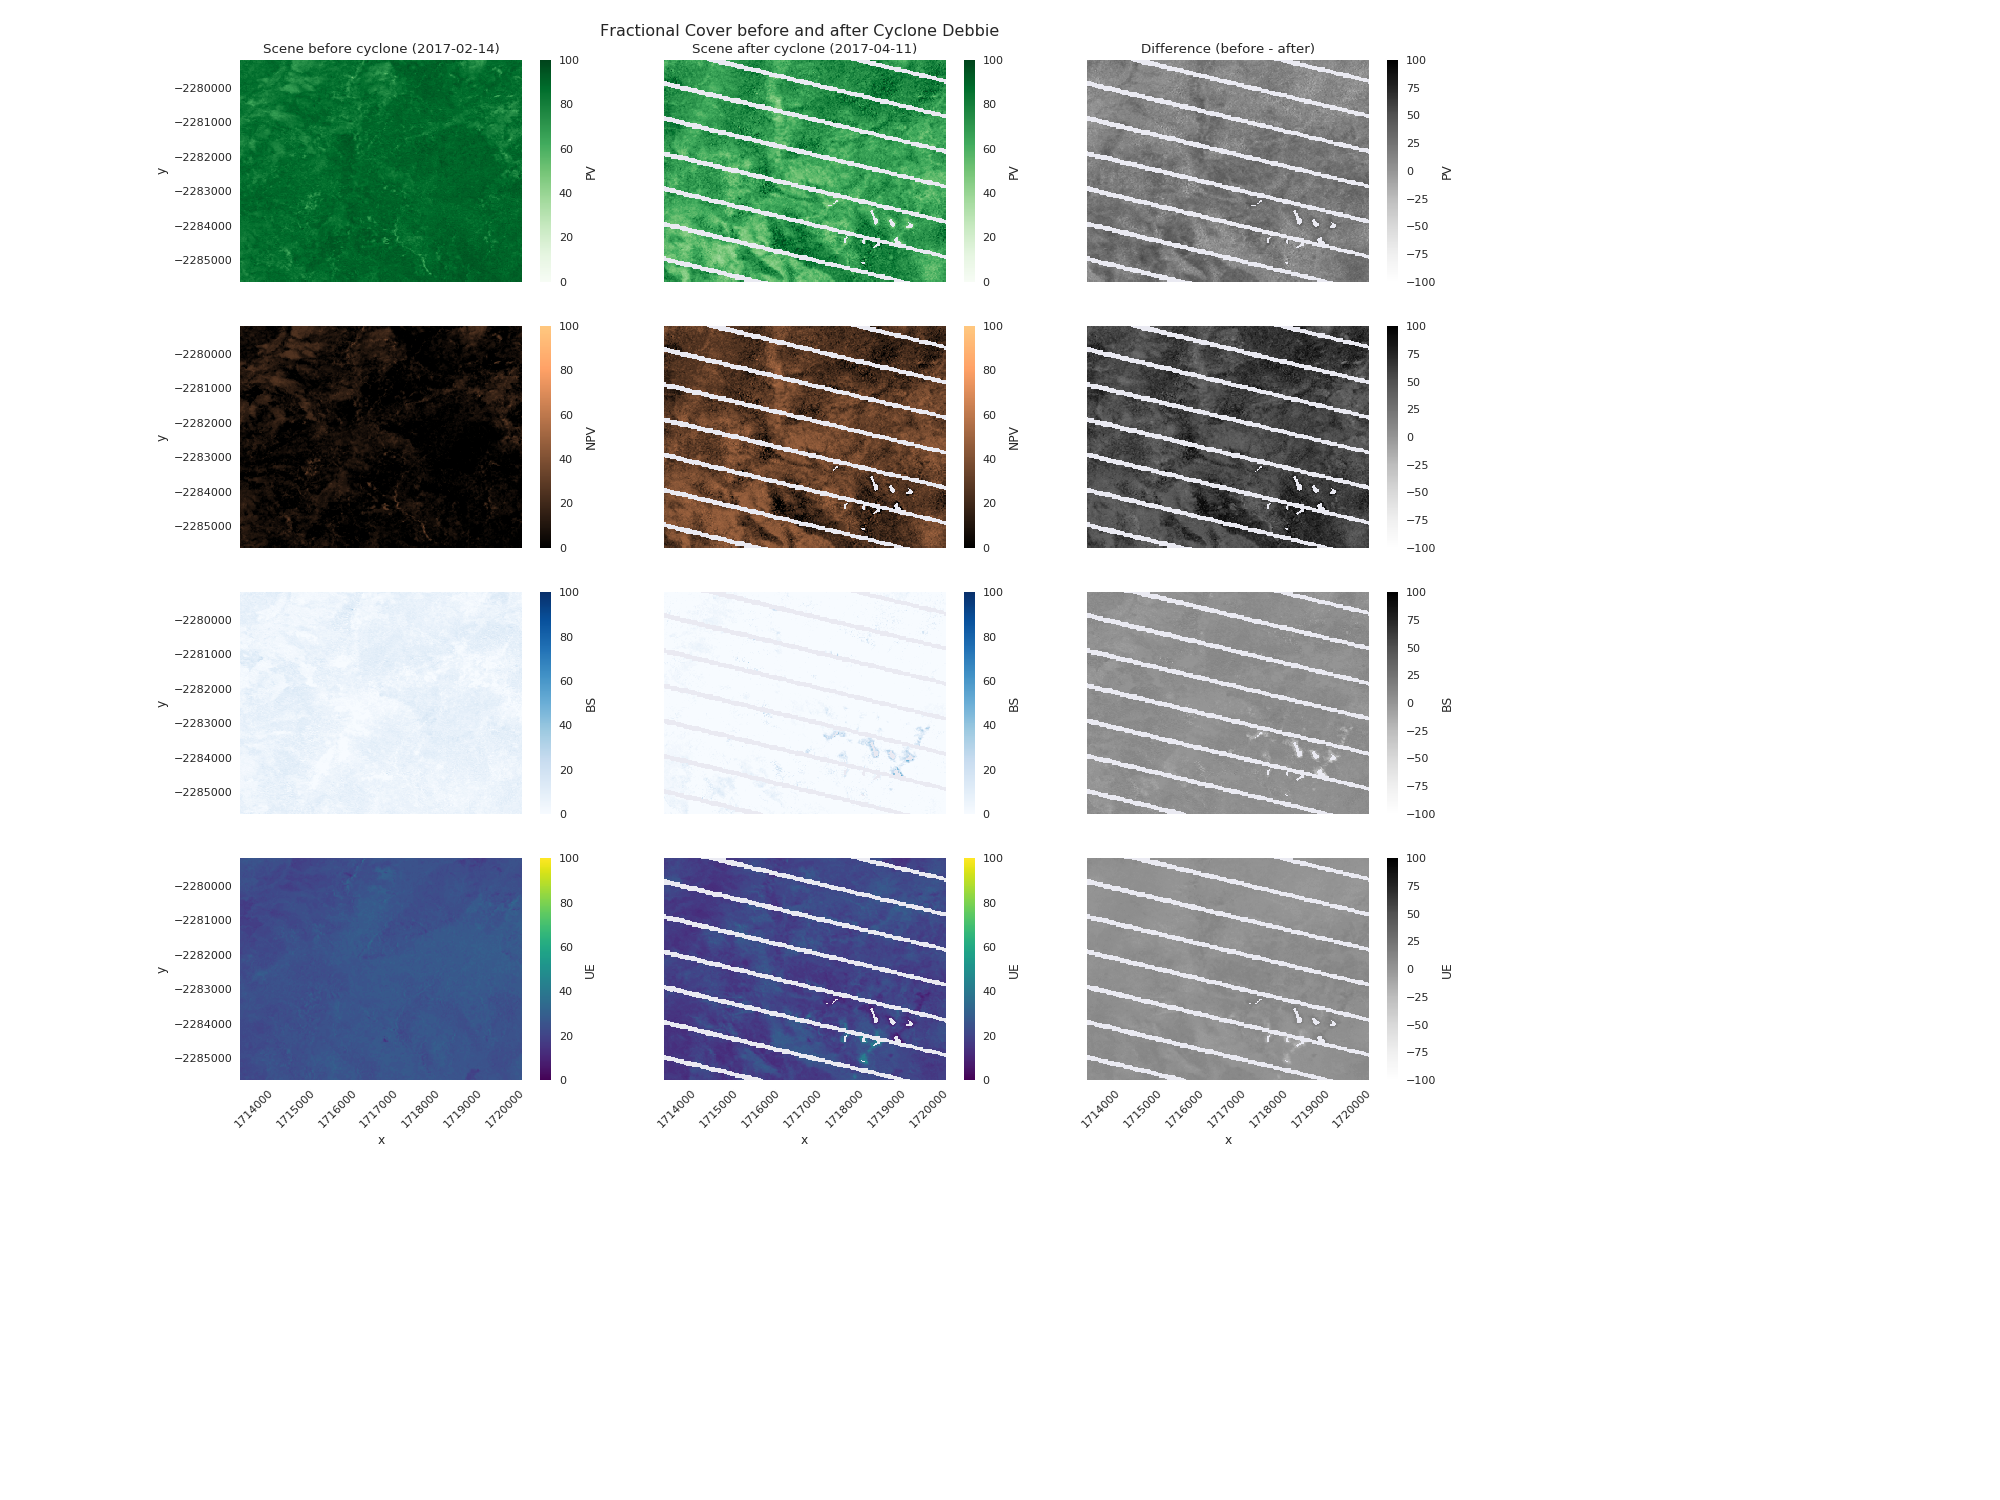

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


In [17]:
# plt.clf()
fig=plt.figure(figsize=(20,15))
plt.subplots_adjust(left=0.15, right=0.90, top=0.95, bottom=0.10) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white
gs = gridspec.GridSpec(4,3)

#PV
ax1=plt.subplot(gs[0,0])
fc_clean.PV.sel(time =start_of_event, method = 'pad').plot(cmap='Greens',vmax=100,vmin=0)
ax1.xaxis.set_visible(False)
ax1.set_title('Scene before cyclone ('+before_date+')')

ax2=plt.subplot(gs[0,1])
fc_clean.PV.sel(time =start_of_event, method = 'backfill').plot(cmap='Greens',vmax=100,vmin=0)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_title('Scene after cyclone ('+after_date+')')

ax3=plt.subplot(gs[0,2])
PV_difference=(fc_clean.PV.sel(time =start_of_event, method = 'pad'))-(fc_clean.PV.sel(time =start_of_event, method = 'backfill'))
PV_difference.plot(cmap='Greys',vmax=100,vmin=-100)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.set_title('Difference (before - after)')

#NPV
ax4=plt.subplot(gs[1,0])
fc_clean.NPV.sel(time =start_of_event, method = 'pad').plot(cmap='copper',vmax=100,vmin=0)
ax4.xaxis.set_visible(False)
ax4.title.set_visible(False)

ax5=plt.subplot(gs[1,1])
fc_clean.NPV.sel(time =start_of_event, method = 'backfill').plot(cmap='copper',vmax=100,vmin=0)
ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)
ax5.title.set_visible(False)

ax10=plt.subplot(gs[1,2])
NPV_difference=(fc_clean.PV.sel(time =start_of_event, method = 'pad'))-(fc_clean.NPV.sel(time =start_of_event, method = 'backfill'))
NPV_difference.plot(cmap='Greys',vmax=100,vmin=-100)
ax10.xaxis.set_visible(False)
ax10.yaxis.set_visible(False)
ax10.title.set_visible(False)

#BS
ax6=plt.subplot(gs[2,0])
fc_clean.BS.sel(time =start_of_event, method = 'pad').plot(cmap='Blues',vmax=100,vmin=0)
ax6.xaxis.set_visible(False)
ax6.title.set_visible(False)

ax7=plt.subplot(gs[2,1])
fc_clean.BS.sel(time =start_of_event, method = 'backfill').plot(cmap='Blues',vmax=100,vmin=0)
ax7.xaxis.set_visible(False)
ax7.yaxis.set_visible(False)
ax7.title.set_visible(False)

ax11=plt.subplot(gs[2,2])
BS_difference=(fc_clean.BS.sel(time =start_of_event, method = 'pad'))-(fc_clean.BS.sel(time =start_of_event, method = 'backfill'))
BS_difference.plot(cmap='Greys',vmax=100,vmin=-100)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)
ax11.title.set_visible(False)

#UE
ax8=plt.subplot(gs[3,0])
fc_clean.UE.sel(time =start_of_event, method = 'pad').plot(vmax=100,vmin=0)
ax8.title.set_visible(False)
ax8.tick_params(axis='x', which='major', labelsize=10, labelrotation=45) 

ax9=plt.subplot(gs[3,1])
fc_clean.UE.sel(time =start_of_event, method = 'backfill').plot(vmax=100,vmin=0)
ax9.yaxis.set_visible(False)
ax9.title.set_visible(False)
ax9.tick_params(axis='x', which='major', labelsize=10, labelrotation=45) 

ax12=plt.subplot(gs[3,2])
UE_difference=(fc_clean.UE.sel(time =start_of_event, method = 'pad'))-(fc_clean.UE.sel(time =start_of_event, method = 'backfill'))
UE_difference.plot(cmap='Greys',vmax=100,vmin=-100)
ax12.tick_params(axis='x', which='major', labelsize=10, labelrotation=45) 
ax12.yaxis.set_visible(False)
ax12.title.set_visible(False)

plt.suptitle('Fractional Cover before and after Cyclone '+str(cyclone_name))
plt.show()

In [18]:
#Save figure
plt.savefig(str(output_folder)+'FC_'+str(cyclone_name)+'_'+str(location_name))

# Create RGB image of FC

In [19]:
rgb = fc_clean.sel(time =start_of_event, method = 'bfill').to_array(dim='color').sel(color=[
    'BS','PV','NPV']).transpose('y', 'x', 'color')
rgb = rgb.astype('double')
max_val = rgb.max(['y', 'x'])
scaled = (rgb / max_val)

<IPython.core.display.Javascript object>


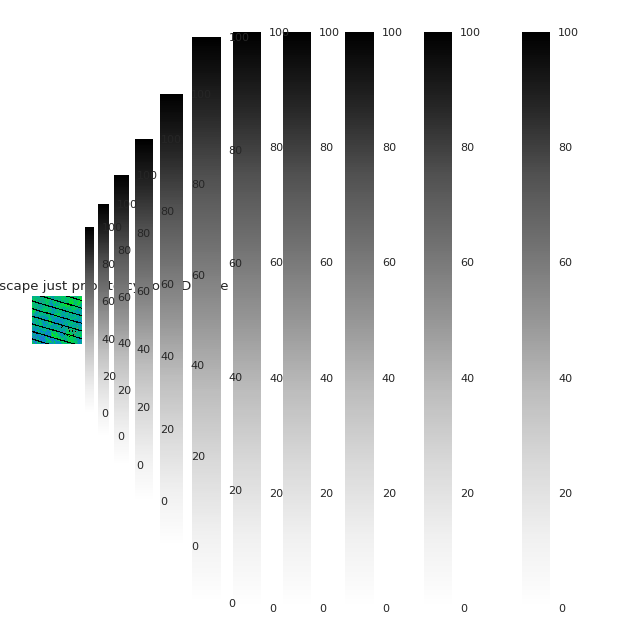

In [20]:
fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis 
plt.title('FC01: ' + str(vegetation_type)+ ' landscape just prior to cyclone '+ str(cyclone_name)) #add title
plt.imshow(scaled, interpolation = 'nearest') #create image
plt.show() #show image


# Create animation that shows landscape before cyclone and then recovery of vegetation over time

In [21]:
animation_start=str(fc_clean.sel(time=start_of_event, method = 'backfill').time.values)
animation_end=str(end_of_event+datetime.timedelta(days=400))

FC_first_scene= str(fc_clean.sel(time=start_of_event, method = 'pad').time.values)
PV_first_scene=str(fc_clean.PV.sel(time=start_of_event, method = 'pad').time.values)
NPV_first_scene=str(fc_clean.NPV.sel(time=start_of_event, method = 'pad').time.values)
BS_first_scene=str(fc_clean.BS.sel(time=start_of_event, method = 'pad').time.values)
UE_first_scene=str(fc_clean.UE.sel(time=start_of_event, method = 'pad').time.values)


FC_animation=fc_clean.sel(time=slice(animation_start,animation_end))
FC_first_scene02=fc_clean.sel(time=slice(FC_first_scene,FC_first_scene))


PV_animation=fc_clean.PV.sel(time=slice(animation_start,animation_end))
PV_first_scene02=fc_clean.PV.sel(time=slice(PV_first_scene,PV_first_scene))

NPV_animation=fc_clean.NPV.sel(time=slice(animation_start,animation_end))
NPV_first_scene02=fc_clean.NPV.sel(time=slice(NPV_first_scene,NPV_first_scene))

BS_animation=fc_clean.BS.sel(time=slice(animation_start,animation_end))
BS_first_scene02=fc_clean.BS.sel(time=slice(BS_first_scene,BS_first_scene))

UE_animation=fc_clean.UE.sel(time=slice(animation_start,animation_end))
UE_first_scene02=fc_clean.UE.sel(time=slice(UE_first_scene,UE_first_scene))

<IPython.core.display.Javascript object>


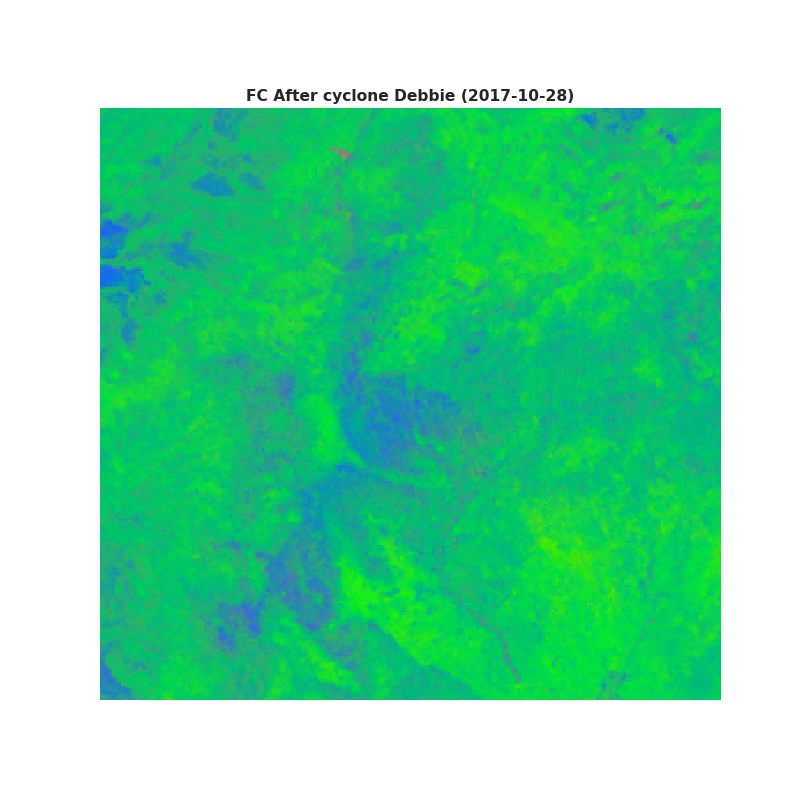

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [22]:
# fig=plt.figure(figsize=(10,20))
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_FC=[]
data_to_plot_FC =[]
first_scene_FC=[]

for t  in range(0,np.shape(FC_animation.time)[0]):
    time_slice = t
    times_to_plot_FC.append(t)
    rgb = FC_animation.isel(time =time_slice).to_array(dim='color').sel(color=[
    'BS','PV','NPV']).transpose('y', 'x', 'color')
    rgb = rgb.astype('double')
    max_val = rgb.max(['y', 'x'])
    scaled = (rgb / max_val)
    data_to_plot_FC.append(scaled)

        
for t  in range(0,np.shape(FC_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_FC.append(t)
    rgb = FC_first_scene02.isel(time =time_slice).to_array(dim='color').sel(color=[
    'BS','PV','NPV']).transpose('y', 'x', 'color')
    rgb = rgb.astype('double')
    max_val = rgb.max(['y', 'x'])
    scaled = (rgb / max_val)
    first_scene_FC.append(scaled)
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('FC Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_FC[0], interpolation = 'nearest', animated = True,cmap='Greens',vmax=100,vmin=0)

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_FC[0])
    time_text.set_text('FC Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_FC[j])
    time_text.set_text('FC After cyclone '+str(cyclone_name)+' ('+ (str(FC_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_FC),
                              interval=2000, blit=True, repeat=False)


np.seterr(invalid='raise')#turn numpy warnings back on


<IPython.core.display.Javascript object>


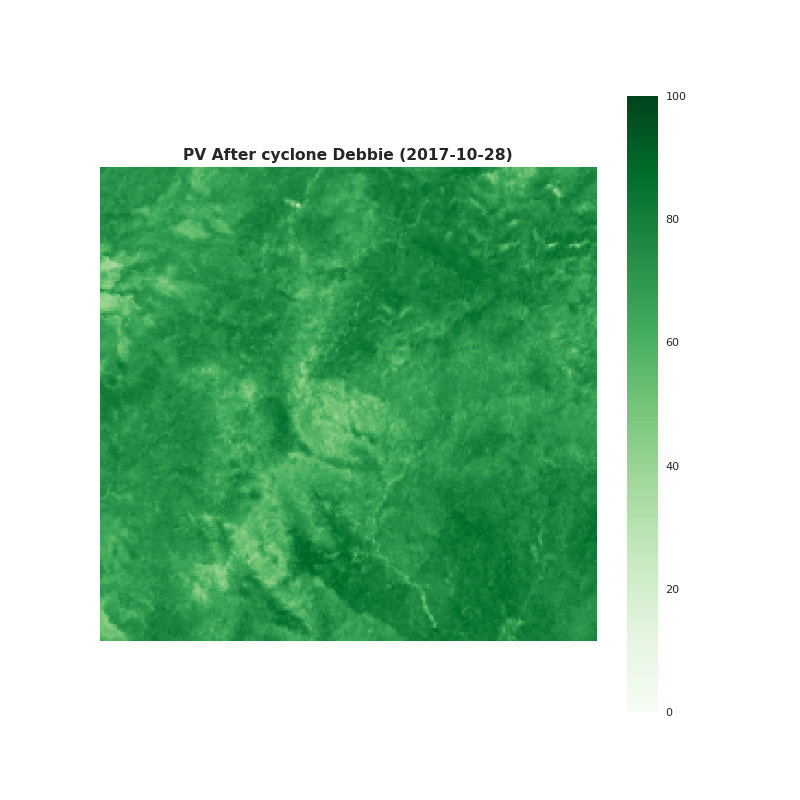

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [23]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_PV=[]
data_to_plot_PV =[]
first_scene_PV=[]

for t  in range(0,np.shape(PV_animation.time)[0]):
    time_slice = t
    times_to_plot_PV.append(t)
    data_to_plot_PV.append(PV_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(PV_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_PV.append(t)
    first_scene_PV.append(PV_first_scene02.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('PV Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_PV[0], interpolation = 'nearest', animated = True,cmap='Greens',vmax=100,vmin=0)
plt.colorbar()

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_PV[0])
    time_text.set_text('PV Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_PV[j])
#     fig.colorbar(im)
    time_text.set_text('PV After cyclone '+str(cyclone_name)+' ('+ (str(PV_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_PV),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on

<IPython.core.display.Javascript object>


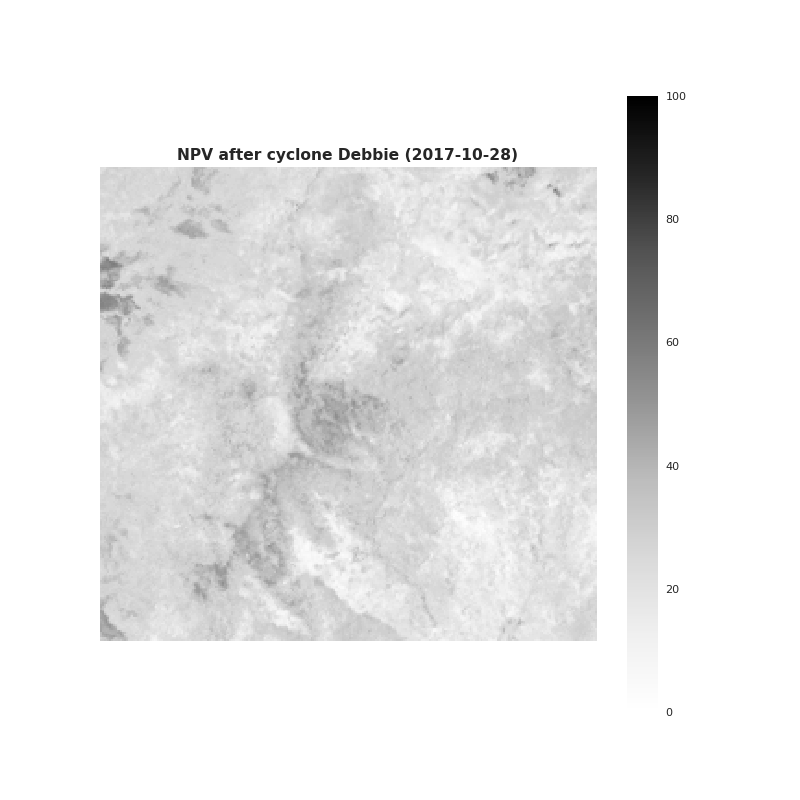

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [24]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_NPV=[]
data_to_plot_NPV =[]
first_scene_NPV=[]

for t  in range(0,np.shape(NPV_animation.time)[0]):
    time_slice = t
    times_to_plot_NPV.append(t)
    data_to_plot_NPV.append(NPV_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(NPV_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_NPV.append(t)
    first_scene_NPV.append(NPV_first_scene02.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('NPV before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_NPV[0], interpolation = 'nearest', animated = True,cmap='Greys',vmax=100,vmin=0)
plt.colorbar()

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_NPV[0])
    time_text.set_text('NPV before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_NPV[j])
    fig.colorbar(im)
    time_text.set_text('NPV after cyclone '+str(cyclone_name)+' ('+ (str(NPV_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_NPV),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on


In [19]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_BS=[]
data_to_plot_BS =[]
first_scene_BS=[]

for t  in range(0,np.shape(BS_animation.time)[0]):
    time_slice = t
    times_to_plot_BS.append(t)
    data_to_plot_BS.append(BS_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(BS_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_BS.append(t)
    first_scene_BS.append(BS_first_scene02.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('BS Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_BS[0], interpolation = 'nearest', animated = True,cmap='Greys',vmax=100,vmin=0)
plt.colorbar()

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_BS[0])
    time_text.set_text('BS Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_BS[j])
    fig.colorbar(im)
    time_text.set_text('BS After cyclone '+str(cyclone_name)+' ('+ (str(BS_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_BS),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on


<IPython.core.display.Javascript object>

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [20]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_UE=[]
data_to_plot_UE =[]
first_scene_UE=[]

for t  in range(0,np.shape(UE_animation.time)[0]):
    time_slice = t
    times_to_plot_UE.append(t)
    data_to_plot_UE.append(UE_animation.isel(time =time_slice))

        
for t  in range(0,np.shape(UE_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_UE.append(t)
    first_scene_UE.append(UE_first_scene02.isel(time =time_slice))
        
        
fig1 = plt.figure(figsize =(10,10), dpi=100)    
time_text = plt.title(('UE Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_UE[0], interpolation = 'nearest', animated = True,cmap='Greys',vmax=100,vmin=0)
plt.colorbar()

plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_UE[0])
    time_text.set_text('UE Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_UE[j])
    fig.colorbar(im)
    time_text.set_text('UE After cyclone '+str(cyclone_name)+' ('+ (str(UE_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_UE),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on


<IPython.core.display.Javascript object>

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [21]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_NPV=[]
data_to_plot_NPV =[]
first_scene_NPV=[]

for t  in range(0,np.shape(NPV_animation.time)[0]):
    time_slice = t
    times_to_plot_NPV.append(t)
    rgb = NPV_animation.isel(time =time_slice)
    fake_saturation = int(6000.0)
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    data_to_plot_NPV.append(scaled)

        
for t  in range(0,np.shape(NPV_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_NPV.append(t)
    rgb = NPV_first_scene02.isel(time =time_slice)#.to_array(dim='color').sel(color=['swir1','nir', 'green']).transpose('y', 'x', 'color')
    fake_saturation = int(6000.0)
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    first_scene_NPV.append(scaled)
        
        
fig1 = plt.figure(figsize =(5,5), dpi=100)    
time_text = plt.title(('Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_NPV[0], interpolation = 'nearest', animated = True,)
colorbar(im)
plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_NPV[0])
    time_text.set_text('Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_NPV[j])
    time_text.set_text('After cyclone '+str(cyclone_name)+' ('+ (str(NPV_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_NPV),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on

<IPython.core.display.Javascript object>

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [22]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_BS=[]
data_to_plot_BS =[]
first_scene_BS=[]

for t  in range(0,np.shape(BS_animation.time)[0]):
    time_slice = t
    times_to_plot_BS.append(t)
    rgb = BS_animation.isel(time =time_slice)
    fake_saturation = int(6000.0)
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    data_to_plot_BS.append(scaled)

        
for t  in range(0,np.shape(BS_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_BS.append(t)
    rgb = BS_first_scene02.isel(time =time_slice)#.to_array(dim='color').sel(color=['swir1','nir', 'green']).transpose('y', 'x', 'color')
    fake_saturation = int(6000.0)
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    first_scene_BS.append(scaled)
        
        
fig1 = plt.figure(figsize =(5,5), dpi=100)    
time_text = plt.title(('Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_BS[0], interpolation = 'nearest', animated = True,)
plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_BS[0])
    time_text.set_text('Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_BS[j])
    time_text.set_text('After cyclone '+str(cyclone_name)+' ('+ (str(BS_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_BS),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on


<IPython.core.display.Javascript object>

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [23]:
np.seterr(invalid='ignore') #ignore numpy warnings so they don't fill the screen
times_to_plot_UE=[]
data_to_plot_UE =[]
first_scene_UE=[]

for t  in range(0,np.shape(UE_animation.time)[0]):
    time_slice = t
    times_to_plot_UE.append(t)
    rgb = UE_animation.isel(time =time_slice)
    fake_saturation = int(6000.0)
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    data_to_plot_UE.append(scaled)

        
for t  in range(0,np.shape(UE_first_scene02.time)[0]):
    time_slice = t
    times_to_plot_UE.append(t)
    rgb = UE_first_scene02.isel(time =time_slice)#.to_array(dim='color').sel(color=['swir1','nir', 'green']).transpose('y', 'x', 'color')
    fake_saturation = int(6000.0)
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)
    first_scene_UE.append(scaled)
        
        
fig1 = plt.figure(figsize =(5,5), dpi=100)    
time_text = plt.title(('Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')'), fontsize=14, fontweight='bold')
im = plt.imshow(first_scene_UE[0], interpolation = 'nearest', animated = True,)
plt.axis('off')#remove axis

#initilise the first frame of the animation
def init():
    im.set_data(first_scene_UE[0])
    time_text.set_text('Before cyclone '+str(cyclone_name)+' ('+ (str(animation_start)[0:10])+')') 
    return im, [time_text]


# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(data_to_plot_UE[j])
    time_text.set_text('After cyclone '+str(cyclone_name)+' ('+ (str(UE_animation.time[j].values)[0:10])+')' )   
    # return the artists set
    return im, [time_text]

ani = animation.FuncAnimation(fig1, updatefig, init_func=init,frames=len(data_to_plot_UE),
                              interval=2000, blit=True, repeat=False)
plt.show()
np.seterr(invalid='raise')#turn numpy warnings back on


<IPython.core.display.Javascript object>

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [24]:
stop here

SyntaxError: invalid syntax (<ipython-input-24-a96ba3aab008>, line 1)

In [ ]:
#Data from different sensors are joined together and sorted so that observations are sorted by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [ ]:
#Check that the concatenation worked

nbar_clean

# Find the scenes that occur before and after cyclone

In [ ]:
#Retun time and sensor information
product_time = nbar_clean[['time']].to_dataframe() #Add time and product to dataframe
product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

In [ ]:
#Save cyclone "event" date in correct format for plotting
event_dates=pd.DataFrame()
delta = end_of_event - start_of_event
for i in range(delta.days + 1):
    date=start_of_event + timedelta(days=i)
    date=pd.DataFrame([date],index=None)
    event_dates=event_dates.append(date)
event_dates.columns=['date']
event_dates=event_dates.set_index('date',drop=False)
event_dates.index=event_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
event_dates['value']=1

In [ ]:
#Save "interest dates" in correct format for plotting. Interest dates are set to help visulise avaliable scenes on either side of the cyclone.
start_of_interest= start_of_event+datetime.timedelta(days=-200) #default of 200 days
end_of_interest= end_of_event+datetime.timedelta(days=200) #default of 200 days

interest_dates=pd.DataFrame()
delta = end_of_interest - start_of_interest
for i in range(delta.days + 1):
    date=start_of_interest + timedelta(days=i)
    date=pd.DataFrame([date],index=None)
    interest_dates=interest_dates.append(date)

interest_dates.columns=['date']
interest_dates=interest_dates.set_index('date',drop=False)
interest_dates.index=interest_dates.index.map(lambda t: t.strftime('%Y-%m-%d'))
interest_dates['value']=1

In [ ]:
#Merge dates of interest with the Landsat scenes to match dates
subset_data = pd.merge(interest_dates, product_time, left_index=True,#left_on= 'date', 
                       right_index=True, how='inner') #Match dates and merge

In [ ]:
product_time

# Create an interactive graph that shows suitable imagery before and after the cyclone

In [ ]:
#Create interactive plot that enables the user to select a scene. User should select a scene before the cyclone event

#create widget that enables interaction with plot
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global date_int, devent
    devent = event
    date_int = event.xdata
    time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(10,8)) #Set plot size
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive graph: imagery avaliable before and after cyclone ' +str(cyclone_name), size=14) #Plot title
display(w) #Plot setup with interactive widget
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.15) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white

#Plot dates of interest, dates of cyclone and dates of imagery
plt.plot_date(interest_dates.date,interest_dates.value, 'g.', 
                            label= 'Time period of interest')
plt.plot_date(event_dates.date,event_dates.value, 'b.', 
                            label= 'Cyclone event')
plt.plot_date(subset_data.date,subset_data.value, 'r.', markersize=20,
                            label= 'Suitable imagery') #the term "suitable" is defined by cloud_free_threshold.
#Axis details
plt.yticks([]) #remove y axis values as not required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot

plt.show() #Plot setup

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'imagery_avaliable_cyclone_'+str(cyclone_name)+'_'+str(location_name))

In [ ]:
#reformat and show date clicked on interactive graph
time_slice = matplotlib.dates.num2date(date_int).date()
# time_slice= np.datetime64(time_slice)
subset_data['date'] = pd.to_datetime(subset_data['date'], format='%Y-%m-%d')
subset_data['difference']=(subset_data['date'] - time_slice).abs() 
time_slice=subset_data.iloc[argsort(subset_data['difference'])].date
time_slice= (list(time_slice)[0])
time_slice_str=datetime.datetime.strftime(time_slice,'%Y-%m-%d')
time_slice

In [ ]:
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=[
    'BS','PV', 'NPV']).transpose('y', 'x', 'color')

In [ ]:
rgb

In [ ]:
fig = plt.figure(figsize =(8,8))
rgb.NPV.plot.imshow(vmin = 0, vmax = 100)
plt.show() #Create image

In [ ]:
#Prepare imagery
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

In [ ]:
#Create image that shows landscape before cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis 
plt.title('Image 01: ' + str(vegetation_type)+ ' landscape prior (' +time_slice_str+ ') to cyclone '+ str(cyclone_name)) #add title
plt.imshow(nbar_clean, interpolation = 'nearest') #create image
plt.show() #show image

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'landscape_image01_'+str(cyclone_name)+'_'+str(location_name)+'_'+time_slice_str)

In [ ]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi_of_interest= ndvi.sel(time = time_slice, method='nearest') #select scene

ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

In [ ]:
#Plot NDVI for scene prior to cyclone

#Controls for NDVI colour map
ndvi_cmap = mpl.colors.ListedColormap(['blue', 'red', 'orange', '#ffcc66','#ffffcc' , '#ccff66' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.5, 0.8, 0.9, 0.95, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

#Create plot
fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.axis('off')#remove axis 
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.title('NDVI 01: ' + str(vegetation_type)+ ' landscape prior (' +time_slice_str+ ') to cyclone '+ str(cyclone_name)) #add title
i=plt.imshow(ndvi_of_interest,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'NDVI01_'+str(cyclone_name)+'_'+str(location_name)+'_'+time_slice_str)

# Landscape and NDVI of scene after cyclone

In [ ]:
#Create interactive plot that enables the user to select a scene. User should select a scene after the cyclone event

#create widget that enables interaction with plot
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global date_int2, devent
    devent = event
    date_int2 = event.xdata
    time_int_ = time_int2.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(10,8)) #Set plot size
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive graph: imagery avaliable before and after cyclone ' +str(cyclone_name), size=14) #Plot title
display(w) #Plot setup with interactive widget
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.15) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white

#Plot dates of interest, dates of cyclone and dates of imagery
plt.plot_date(interest_dates.date,interest_dates.value, 'g.', 
                            label= 'Time period of interest')
plt.plot_date(event_dates.date,event_dates.value, 'b.', 
                            label= 'Cyclone event')
plt.plot_date(subset_data.date,subset_data.value, 'r.', markersize=20,
                            label= 'Suitable imagery') #the term "suitable" is defined by cloud_free_threshold.
#Axis details
plt.yticks([]) #remove y axis values as not required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=14) #Set legend location on plot

plt.show() #Plot setup

In [ ]:
#reformat and show date clicked on interactive graph
time_slice02 = matplotlib.dates.num2date(date_int2).date()
subset_data['date'] = pd.to_datetime(subset_data['date'], format='%Y-%m-%d')
subset_data['difference']=(subset_data['date'] - time_slice02).abs() 
time_slice02=subset_data.iloc[argsort(subset_data['difference'])].date
time_slice02= (list(time_slice02)[0])
time_slice02_str=datetime.datetime.strftime(time_slice02,'%Y-%m-%d')
time_slice02

In [ ]:
#Prepare imagery for scene after cyclone

rgb02 = nbar_clean.sel(time =time_slice02, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb02 = rgb02.astype('double')
clipped_visible02 = rgb02.where(rgb02<fake_saturation).fillna(fake_saturation)
max_val02 = clipped_visible02.max(['y', 'x'])
scaled02 = (clipped_visible02 / max_val02)

In [ ]:
#Create image that shows landscape after cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis
plt.title('Image 02: ' + str(vegetation_type)+ ' landscape after ('+time_slice02_str+ ') cyclone '+ str(cyclone_name)) #add title
plt.imshow(scaled02, interpolation = 'nearest') #create image
plt.show() #show image

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'landscape_image02_'+str(cyclone_name)+'_'+str(location_name)+'_'+time_slice_str) 

In [ ]:
#Select NDVI for scene after cyclone
ndvi_of_interest02= ndvi.sel(time = time_slice02, method='nearest')
ndvi_of_interest02

In [ ]:
#Plot NDVI for scene after cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.axis('off')#remove axis 
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.title('NDVI 02: ' + str(vegetation_type)+ ' landscape after (' +time_slice_str+ ') cyclone '+ str(cyclone_name)) #add title
i=plt.imshow(ndvi_of_interest02,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'NDVI02_'+str(cyclone_name)+'_'+str(location_name)+'_'+time_slice_str)

# Change in vegetation before/after cyclone

In [ ]:
#Calculate the difference in NDVI from before to after cyclone

ndvi_change= ndvi_of_interest02-ndvi_of_interest
ndvi_change.attrs['affine'] = affine

In [ ]:
#Plot the change of NDVI
fig = plt.figure(figsize=(10,8)) #create plot
ndvi_change.plot(cmap = 'RdYlGn',vmin=-1,vmax=1) #create image
plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.title('NDVI difference for '+str(vegetation_type)+ ' landscape before and after Cyclone '+str(cyclone_name)) #add title
plt.axis('off')#remove axis
plt.show() #show image

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'NDVI_change_'+str(cyclone_name)+'_'+str(location_name))

# Import and process windfield data to ensure pixel size and projection is the same as NDVI dataset

In [ ]:
#read windfield geotiff
windfield = gdal.Open(input_folder+'Final_corrected_TCDebbie_wind.tif', gdal.GA_ReadOnly)
windfield

In [ ]:
#get projection information from windfiled
windfield_proj = windfield.GetProjection()
windfield_proj

In [ ]:
#Convert NDVI data array to raster saved in memory

#save NDVI_change dataset to a numpy array
ndvi_array = np.asarray(ndvi_change)

#define conversion variables
cols= int(ndvi_change.x.count())
rows= int(ndvi_change.y.count())
originX= ndvi_change.affine.c
dx= ndvi_change.affine.a
originY= ndvi_change.affine.f
dy= ndvi_change.affine.e
epsg=int((str(crs)).replace('EPSG:',''))
nodata=0

#complete conversion of NDVI array into raster
driver = gdal.GetDriverByName('MEM')
ndvi_raster = driver.Create('ndvi', cols, rows, 1, gdal.GDT_Float32)
ndvi_raster.SetGeoTransform((originX, dx, 0, originY, 0, dy))
ndvi_band = ndvi_raster.GetRasterBand(1)
ndvi_band.WriteArray(ndvi_array)
ndvi_band.SetNoDataValue(nodata)
ndvi_raster_SRS = osr.SpatialReference()
ndvi_raster_SRS.ImportFromEPSG(epsg)
ndvi_raster.SetProjection(ndvi_raster_SRS.ExportToWkt())
ndvi_band.FlushCache()

In [ ]:
#Save metadata from NDVI_change
match_ds = ndvi_raster
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

In [ ]:
#Create a  geotiff that is the same size and is in the same projection as the NDVI dataset
drv = gdal.GetDriverByName('GTiff')
windfield_matched = drv.Create('ouput_file', wide, high, 1, gdal.GDT_Float32)
windfield_matched.SetGeoTransform(match_geotrans)
windfield_matched.SetProjection(match_proj)

#create windfield geotiff
resampling_method = gdalconst.GRA_Bilinear
gdal.ReprojectImage(windfield, windfield_matched, windfield_proj, match_proj, resampling_method)

#view datasets and projections to ensure information looks correct
print ('windfield       = ', windfield)
print ('windfield_matched             = ',windfield_matched)
print ('windfield_proj        = ',windfield_proj)
print ('match_proj      = ',match_proj)

# Save resampled windfield as an array and check array shape

In [ ]:
windfield_matched_array=windfield_matched.ReadAsArray()

print('windfield shape = '+ str(shape(windfield_matched_array)))
print('ndvi_change shape = '+ str(shape(ndvi_change.values)))

In [ ]:
windfield_matched_array

In [ ]:
ndvi_change

# Create a plot that examines relationship between wind and change in NDVI after a cyclone

In [ ]:
#set variables to allow automatic X-axis on plot
x_min=np.around(np.amin(windfield_matched_array),decimals=-1)-10
x_max=np.around(np.amax(windfield_matched_array),decimals=-1)+10
x_num= np.around(np.amax(windfield_matched_array)-np.amin(windfield_matched_array))

In [ ]:
coords_da={'y': ndvi_change.y, 'x': ndvi_change.x}
windfield_da = xr.DataArray(windfield_matched_array, dims=('y','x'), coords=coords_da)
dataset = xr.Dataset({'ndvi_dataset': ndvi_change, 'windfield_dataset': windfield_da})

i=dataset.groupby_bins(dataset.windfield_dataset,bins=x_num,include_lowest=True)
blah=i.mean()
blah

In [ ]:
#create plot that compares change in NDVI and windfield values
fig = plt.figure(figsize=(10,6))
plt.plot(windfield_matched_array, ndvi_change.values, 'o', markeredgecolor='red', markeredgewidth=0.5, markerfacecolor='None') 
plot(blah.windfield_dataset,blah.ndvi_dataset, 'k')

plt.axis([x_min , x_max ,-1.0, 1.0], 'tight')
plt.xlabel('Modelled wind field (m s$^{-1}$)') #Set X label
plt.ylabel('Change in NDVI before and after cyclone '+str(cyclone_name)) #Set Y label
plt.plot([x_min, x_max], [0,0], 'k-', lw=1) #add blackline at 0 to plot
fig.patch.set_facecolor('white') #Make background white
fig.patch.set_alpha(0.99)#Make border white
plt.show()

In [ ]:
#Save figure
plt.savefig(str(output_folder)+'windfield_vs_NDVIchange'+str(cyclone_name)+'_'+str(location_name))

In [ ]:
# i=dataset.groupby_bins(dataset.windfield_dataset,bins=x_num)
# blah=i.mean()
# plot(blah.windfield_dataset,blah.ndvi_dataset)
# fig = plt.figure(figsize=(10,6))
# plt.show()

In [ ]:
# dataset.ndvi_dataset.where(xr.plot.hist(dataset.windfield_dataset))

In [ ]:
# blah= [51.35159302,  54.24769363,  57.14379425,  60.03989487,
#          62.93599548,  65.8320961 ,  68.72819672,  71.62429733,
#          74.52039795,  77.41649857,  80.31259918]

In [ ]:
# blah

In [ ]:
# ndvi_change